In [11]:
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.python.keras.callbacks import LearningRateScheduler
from tensorflow.python.keras.layers import \
    Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.python.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt

from src.util.load_dataset import load_dataset
from src.util.plotting_functions import \
    plot_accuracy, plot_confusion_matrix

# load and preprocess datasets
train, x_train, y_train = load_dataset('../dataset/sign_mnist_train.csv')
test, x_test, y_test = load_dataset('../dataset/sign_mnist_test.csv')
y_true = test['label']

_, x_test_user_0, y_test_user_0 \
    = load_dataset('../dataset/sign_mnist_test_user_0.csv')
_, x_test_user_1, y_test_user_1 \
    = load_dataset('../dataset/sign_mnist_test_user_1.csv')
_, x_test_user_2, y_test_user_2 \
    = load_dataset('../dataset/sign_mnist_test_user_2.csv')

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)
data_generator = ImageDataGenerator(rotation_range=10,
                                    zoom_range=0.10,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1)
save_plots = False

In [12]:
model = Sequential([
    # 2D convolution layer
    Conv2D(filters=32,  # number of neurons, found out through experiments
           kernel_size=(5, 5),
           strides=(1, 1),
           padding='valid', # no padding
           activation='relu',
           input_shape=(28, 28, 1), # first layer in model
                                    # (height x width x channels)
           data_format='channels_last',
           name='input_layer'),
    # use max pooling since we want to extract the most salient features
    # rather than average features
    MaxPool2D(pool_size=(2, 2),
              strides=(2, 2),
              padding='valid', # no padding
              data_format='channels_last',
              name='max_pool_1'),
    Dropout(rate=0.3, seed=None, name='dropout_1'),

    Conv2D(filters=64,
           kernel_size=(5, 5),
           strides=(1, 1),
           padding='valid',
           activation='relu',
           name='second_conv2D'),
    MaxPool2D(pool_size=(2, 2),
              strides=(2, 2),
              padding='valid',
              data_format='channels_last',
              name='max_pool_2'),
    Dropout(rate=0.3, seed=None, name='dropout_2'),

    Flatten(name='flatten'),
    Dense(units=128, activation='relu', name='dense'),
    Dropout(rate=0.3, seed=None, name='dropout_3'),
    Dense(units=24,
          activation='softmax',
          name='output_layer')
])
model._name="Sign_MNIST_CNN"
model.summary() # prints model summary

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

if save_plots:
    plot_model(model,
               to_file='../plots/model_plot.png',
               show_shapes=True,
               show_layer_names=False,
               rankdir='TB',
               dpi=200)

Model: "Sign_MNIST_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Conv2D)         (None, 24, 24, 32)        832       
_________________________________________________________________
max_pool_1 (MaxPooling2D)    (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
second_conv2D (Conv2D)       (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pool_2 (MaxPooling2D)    (None, 4, 4, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)           

In [15]:
# if set to 0.2 that means that 20% of training data
# will be used in evaluation set
x_train2, x_val, y_train2, y_val = \
    train_test_split(x_train,
                     y_train,
                     test_size=0.2,
                     # random_state=42, # only for testing
                     # shuffle=False) # only for testing
                     )

# TRAINING
# without data augmentation
# history = model.fit(x_train2,
#                     y_train2,
#                     batch_size=64, # maybe change to 64!?
#                     epochs=10,
#                     validation_data=(x_val, y_val),
#                     callbacks=[annealer],
#                     verbose=1)

# with data augmentation
history = model.fit(data_generator.flow(x_train2, y_train2, batch_size=64),
                    batch_size=64,
                    epochs=10,
                    validation_data=(x_val, y_val),
                    callbacks=[annealer],
                    verbose=1)

print("\nTrain accuracy={}, Validation accuracy={}\n".format(
        max(history.history['accuracy']),
        max(history.history['val_accuracy'])))

results = model.evaluate(x_test, y_test, verbose=1)
results2 = model.evaluate(x_test_user_0, y_test_user_0, verbose=1)
results3 = model.evaluate(x_test_user_1, y_test_user_1, verbose=1)
results4 = model.evaluate(x_test_user_2, y_test_user_2, verbose=1)
print("\ntest loss, test acc:", results)
print("\ntest loss, test acc T1:", results2)
print("\ntest loss, test acc T2:", results3)
print("\ntest loss, test acc T3:", results4)

Epoch 1/10
344/344 [==============================] - 4s 10ms/step - loss: 0.3071 - accuracy: 0.8986 - val_loss: 0.0281 - val_accuracy: 0.9989

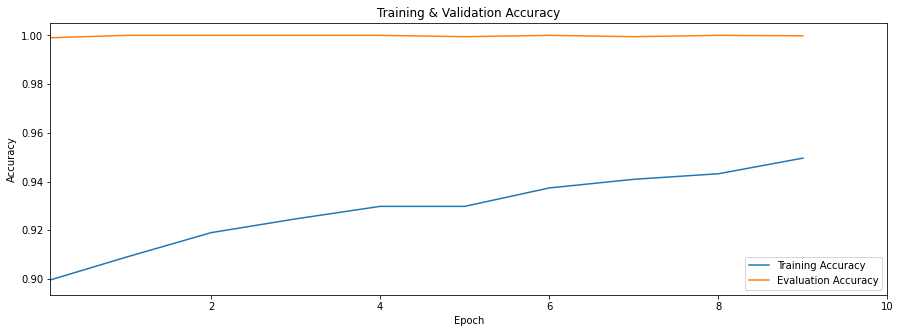

In [17]:
plot_accuracy(history, 'Training & Validation Accuracy')

y_pred = np.argmax(model.predict(x_test), axis=-1)

for i in range(len(y_pred)):
    if y_pred[i] >= 9:
        y_pred[i] += 1
classes = [i for i in range(25) if i != 9]
classes_names = ["Class " + str(i) for i in classes]

print(classification_report(y_true, y_pred, target_names=classes_names))
# only for latex
# report = classification_report(y_true, y_pred, target_names=classes_names,
#                                output_dict=True)
# df = pd.DataFrame(report).transpose()
# print(df.to_latex(index=True, float_format="%.2f"))

plt.figure()
sns.countplot(train['label']).set_title('Train Set')

plot_confusion_matrix(y_true, y_pred, classes)